In [3]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np

nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j')
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 1851


In [4]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [5]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [j for j in g.neighbors(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for n in neighbors:
            sum += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.739243e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.622885e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,6.018484e+06


In [6]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print(g['France']['Germany'])
print(g['France']['United Kingdom'])

{'weight': 88582.44661152952}
{'weight': 62802.53397113779}


In [7]:
# Initialisation for our model :
r0 = 3
alpha = 0.06
beta = 1
period = 10
mortality_rate = 0.2
country_start = 'France'
nb_infected_start = 100

# # Initialisation for t=0 :
countries['incubation0'] = np.zeros(countries.shape[0])
countries['sick0'] = np.zeros(countries.shape[0])
countries['recovered0'] = np.zeros(countries.shape[0])
countries['infected0'] = np.zeros(countries.shape[0])
countries['healthy0'] = countries['population']
# We infect the starting country with a certain number of people
countries.loc[country_start]['infected0'] = nb_infected_start
countries.loc[country_start]['incubation0'] = nb_infected_start
countries.loc[country_start]['healthy0'] = countries.loc[country_start]['population'] - countries.loc[country_start]['incubation0']

(array([ 2.,  6., 12., 10., 11., 19., 25., 24., 17., 25.]),
 array([0.354 , 0.4132, 0.4724, 0.5316, 0.5908, 0.65  , 0.7092, 0.7684,
        0.8276, 0.8868, 0.946 ]),
 <a list of 10 Patch objects>)

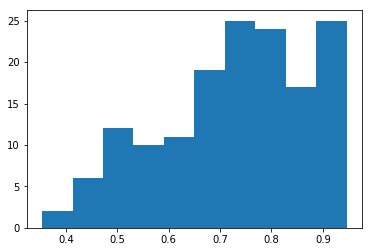

In [24]:
from matplotlib import pyplot
pyplot.hist(countries['hdi'])

(array([25., 17., 24., 25., 19., 11., 10., 12.,  6.,  2.]),
 array([1.32373367, 1.42120261, 1.51867156, 1.61614051, 1.71360945,
        1.8110784 , 1.90854735, 2.00601629, 2.10348524, 2.20095419,
        2.29842313]),
 <a list of 10 Patch objects>)

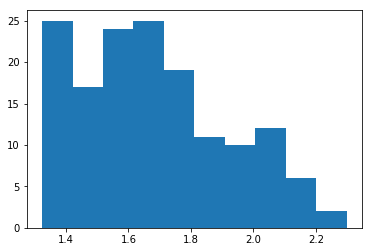

In [50]:
test = ((1 -beta*countries['hdi'])*r0 + 0.75*r0)*exp(-alpha*10)

pyplot.hist(test)

In [9]:
def time(t):
    return exp(-alpha*t)

# We calculate the average number infected by an incubated person in a week
def reproduction_number_by_country(t):
    return (1 -beta*countries['hdi'] + 0.75)*r0*time(t)
    
def number_incubated(t):
    ri = reproduction_number_by_country(t)
    incubation_staying = {}
    incubation_coming = {}
    for i in countries.index:
        incubation_staying[i] = countries.loc[i]['incubation'+str(t-1)]*(1 - 
                                1/(countries.loc[i]['healthy'+str(t-1)]
                        - countries.loc[i]['sick'+str(t-1)]))*countries.loc[i]['sum_travel_neighbors']
        #incubation coming
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*countries.loc[j]['incubation'+str(t-1)]/(countries.loc[j]['healthy'+str(t-1)] -
                                      countries.loc[j]['sick'+str(t-1)])
        incubation_coming[i] = sum
    
    countries['recovered'+str(t)] = (1 - mortality_rate)*countries['sick'+str(t-1)]
    countries['infected'+str(t)] = [((incubation_staying[i] 
                + incubation_coming[i])*(1 + ri[i]) - 
                countries.loc[i]['recovered'+str(t)]) for i in countries.index]
    
    countries['healthy'+str(t)] = [countries.loc[i]['population'] - countries.loc[i]['infected'+str(t)] for i in countries.index]
    countries['sick'+str(t)] = countries['incubation'+str(t - 1)] 
    countries['incubation'+str(t)] = countries['infected'+str(t)] - countries['sick'+str(t)]
    
number_incubated(1)
print('France :', countries.loc['France']['infected1'],  countries.loc['France']['healthy1'])
print('Germany :', countries.loc['Germany']['infected1'],  countries.loc['Germany']['healthy1'])
number_incubated(2)
print('France :', countries.loc['France']['infected2'],  countries.loc['France']['healthy2'])
print('Germany :', countries.loc['Germany']['infected2'],  countries.loc['Germany']['healthy2'])

France : 8066494086.322708 -8002294086.322708
Germany : 0.4774076988840982 81499999.5225923
France : 6.506832705968794e+17 -6.506832705326794e+17
Germany : 36922355.87764224 44577644.12235776


In [ ]:
'''
#nx.draw(g, pos=nx.spring_layout(g), node_color='b', node_size=50, with_labels=True)
#nx.draw_networkx_nodes(g, pos=nx.spring_layout(g), node_color='b', node_size=50, with_labels=True)
#nx.draw_networkx_labels(g, pos=nx.spring_layout(g))
#plt.show()


# create a copy and save
def number_of_incubated(t):
    ri = reproduction_number_by_country(countries['country'], t)
    countries['infected'] = (countries['incubation'] -
                            (countries['incubation']/(countries['healthy']-countries['sick']))
                             *country_info[['country']==countries['country']]['nb_voy']) * (1 + ri)
    neighbors = get_neighbors([countries['country']])
    weights = []
    for n in neighbors:
        weights.append(nodes[['i'] == countries['country'] and nodes[['i'] == n]
    return countries

def number_incubated(nodes, i, t):
    ri = reproduction_number_by_country(countries['country'], t)
    neighbors = get_neighbors(i)

    res = countries[['country'] == i]['incubation'] - countries[['country'] == i]['incubation'] / \
    (countries[['country'] == i]['healthy']-countries[['country'] == i]['sick'])* \
    country_info[['country']==i]['nb_voy'] \
    * (1 + ri)
    sum = 0
    for n in neighbors:
        weight = nodes[nodes[['i']== n and nodes[['j'] == i]]['weight']]
        r = weight * (countries[['country']==i]['incubation'] / countries[['country']==i]['inhabitants']
                      - countries[['country']==n]['sick']) * (1 + ri)
        sum += r
    return res + sum


for t in range(1, 10):
    # we do the action over the df of countries
    countries['incubation'] = number_of_incubated(nodes, i, t)
    countries['inhabitants'] = countries['inhabitants'] - mortality_rate * countries['sick']
    countries['recover'] = countries['sick'] * (1 - mortality_rate)
    # next period the incubated people become sick
    countries['sick'] = countries['incubated']
    countries['infected'] = countries['sick'] + countries['incubation']
    countries['healthy'] = countries['inhabitants'] - countries['infected']'''